# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [149]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')
from operator import add
import re
from utils import *
import json
import numpy as np


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [2]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "4")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [3]:
!hdfs dfs -ls data/ml-25m/

Found 10 items
-rw-r--r--   1 root supergroup      10460 2021-02-14 19:11 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-14 19:11 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-14 19:11 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-14 19:11 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-14 19:11 data/ml-25m/ml-25m-README.htm
drwxr-xr-x   - root supergroup          0 2021-02-15 08:57 data/ml-25m/movie_avg_rating
-rw-r--r--   1 root supergroup    3038099 2021-02-14 19:20 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-14 19:11 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-14 19:11 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-14 19:11 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [4]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [17]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
%%time
ratings.take(5)

CPU times: user 8.11 ms, sys: 0 ns, total: 8.11 ms
Wall time: 2.36 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [20]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [21]:
ratings.count()

25000095

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 15.3 ms, sys: 2.74 ms, total: 18 ms
Wall time: 53.6 s


162541

Сохраним датасет в память

In [22]:
ratings = ratings.persist()

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 1min 27s


162541

Количество фильмов

In [12]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 31.8 ms, sys: 14.7 ms, total: 46.4 ms
Wall time: 55.6 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [494]:
movies = sc.textFile(MOVIES_PATH)
#movies = movies.sample(False, 0.1)

movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [45]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [46]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [47]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-15 08:57 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2021-02-15 08:57 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [48]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [53]:
tags.count()

1093361

In [54]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [55]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

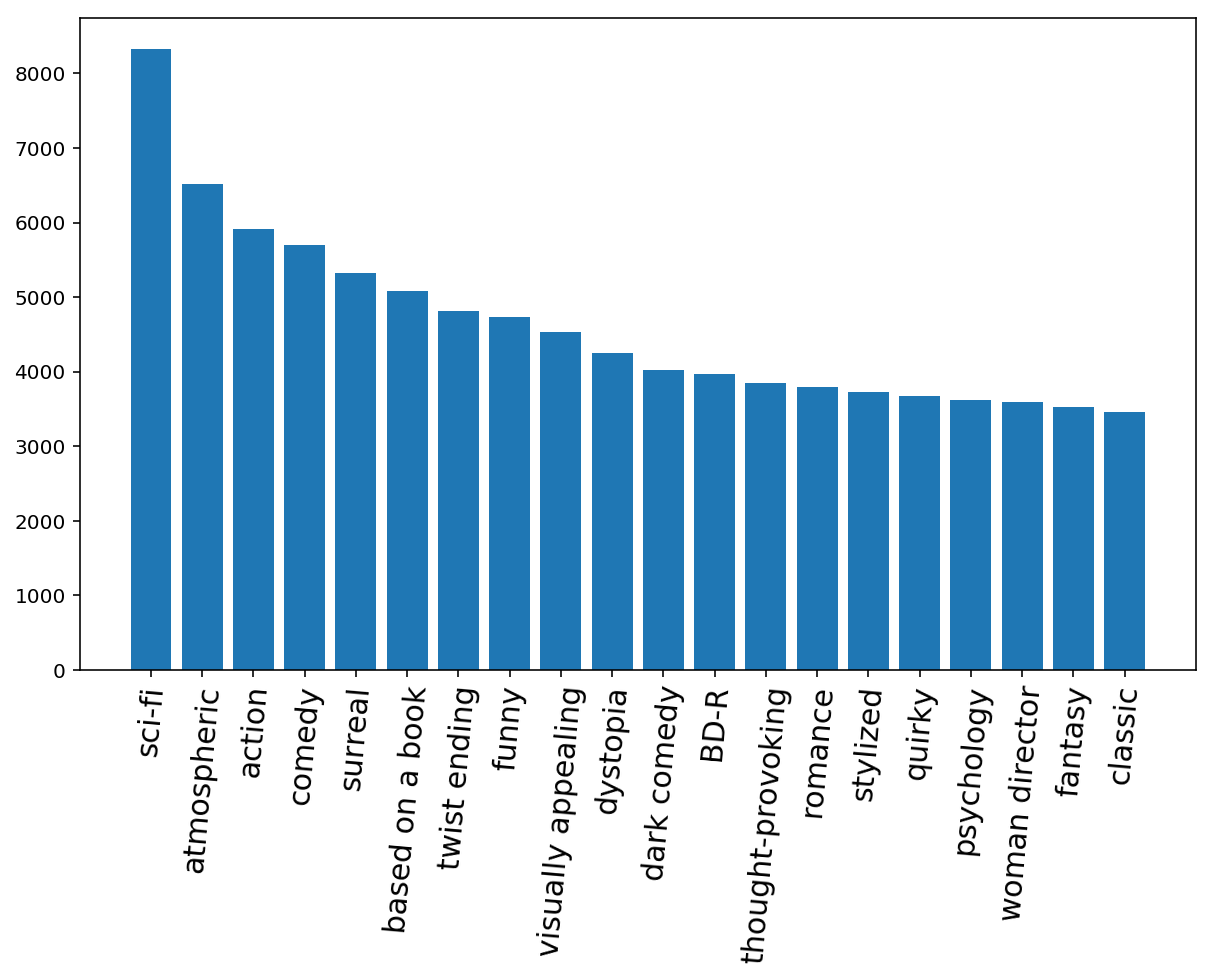

In [56]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [97]:
######################################
######### YOUR CODE HERE #############
######################################
votes = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .map(lambda r: (r[1][1][1], r[1][0]))

votes.take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [82]:
######################################
######### YOUR CODE HERE #############
######################################
ratings \
    .filter(lambda r: r.rating == 5.0) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .map(lambda r: (r[1][1][1], r[1][0])) \
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [94]:
######################################
######### YOUR CODE HERE #############
######################################
import numpy as np
movie_avg_rating_collected = movie_avg_rating.values().collect()

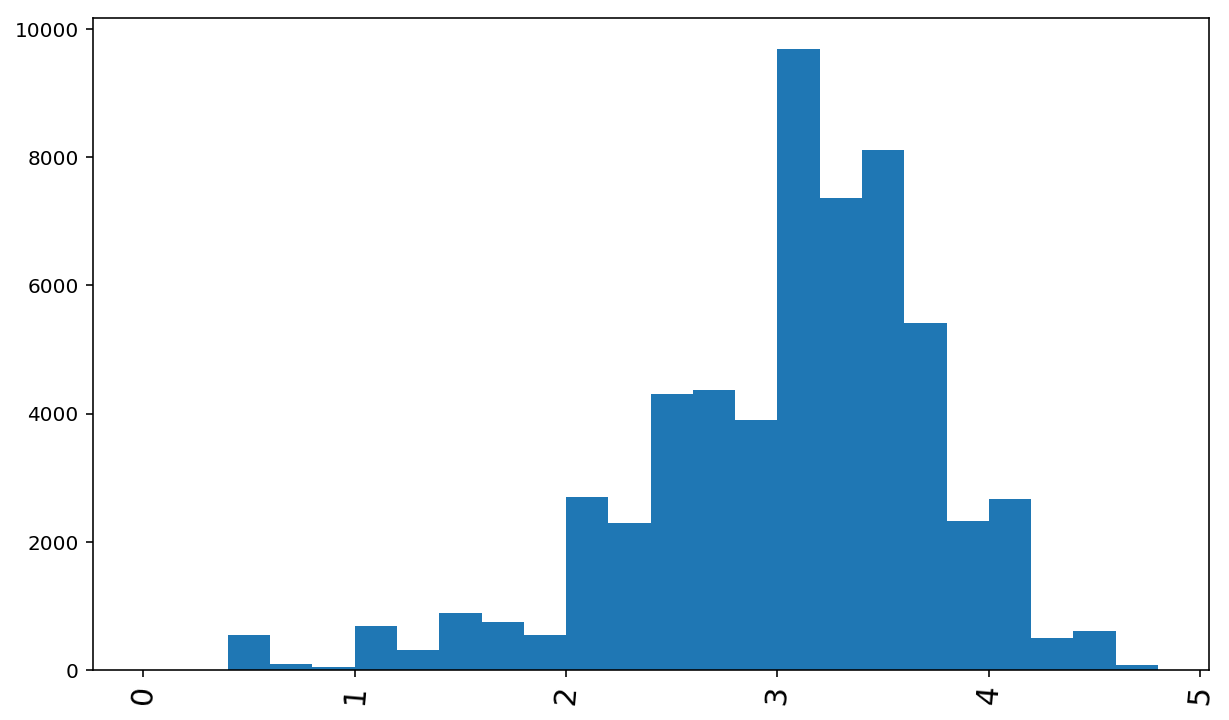

In [96]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.hist(movie_avg_rating_collected, bins=np.arange(start=0.0, stop=5.0, step=0.2))
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

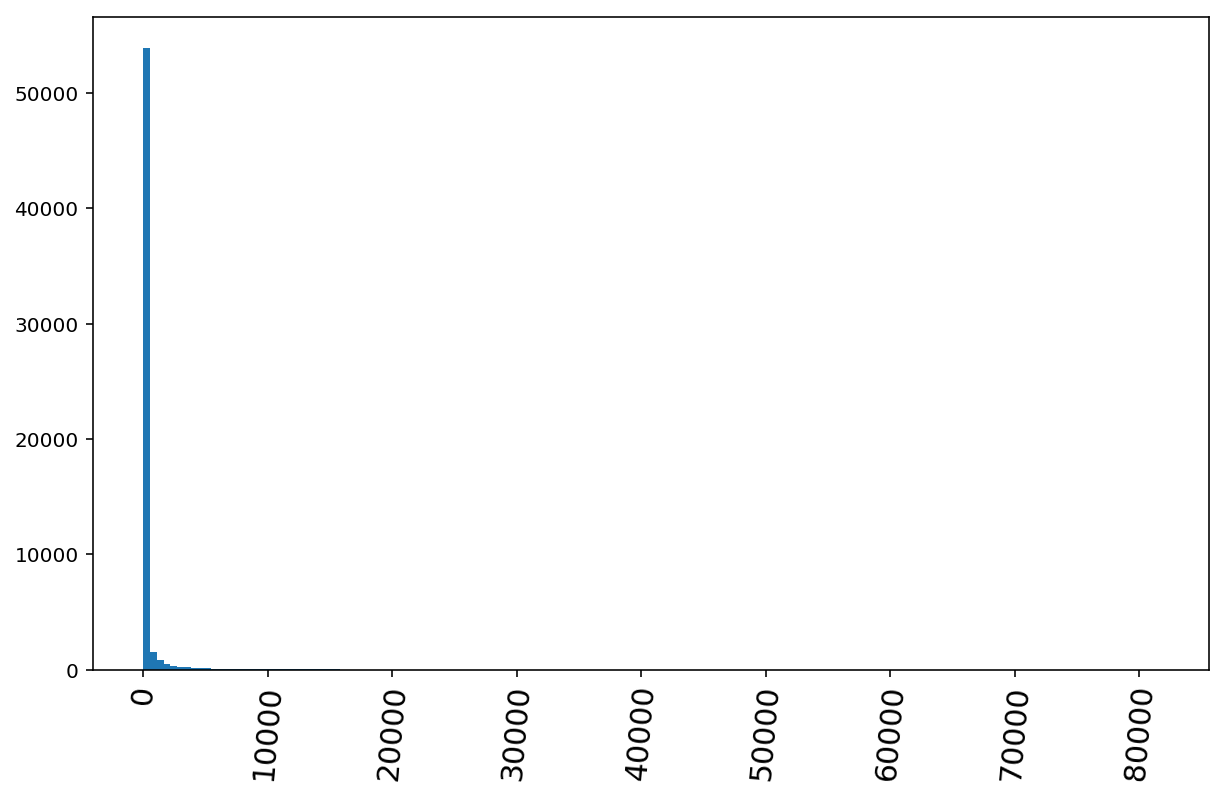

In [102]:
######################################
######### YOUR CODE HERE #############
######################################
votes_collected = votes.values().collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.hist(votes_collected, 150)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [20]:
movies = sc.textFile(MOVIES_PATH)
header = movies.first()
movies = movies.filter(lambda row: row != header)
movies.take(5)
######################################
######### YOUR CODE HERE #############
######################################

['1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance',
 '5,Father of the Bride Part II (1995),Comedy']

In [21]:
comma_matcher = re.compile(r',(?=(?:[^"]*"[^"]*")*[^"]*$)')

In [22]:
genres = movies \
    .map(lambda s: comma_matcher.split(s)[2]) \
    .flatMap(lambda x: x.split('|')) \
    .map(lambda g: (g, 1)) \
    .reduceByKey(add)

In [23]:
genres.take(5)

[('Sci-Fi', 3595),
 ('Horror', 5989),
 ('Drama', 25606),
 ('Action', 7348),
 ('Western', 1399)]

In [24]:
genres_collected = genres.collect()

In [237]:
genres_collected = sorted(genres_collected, key=lambda genre_collected: genre_collected[1], reverse=True)

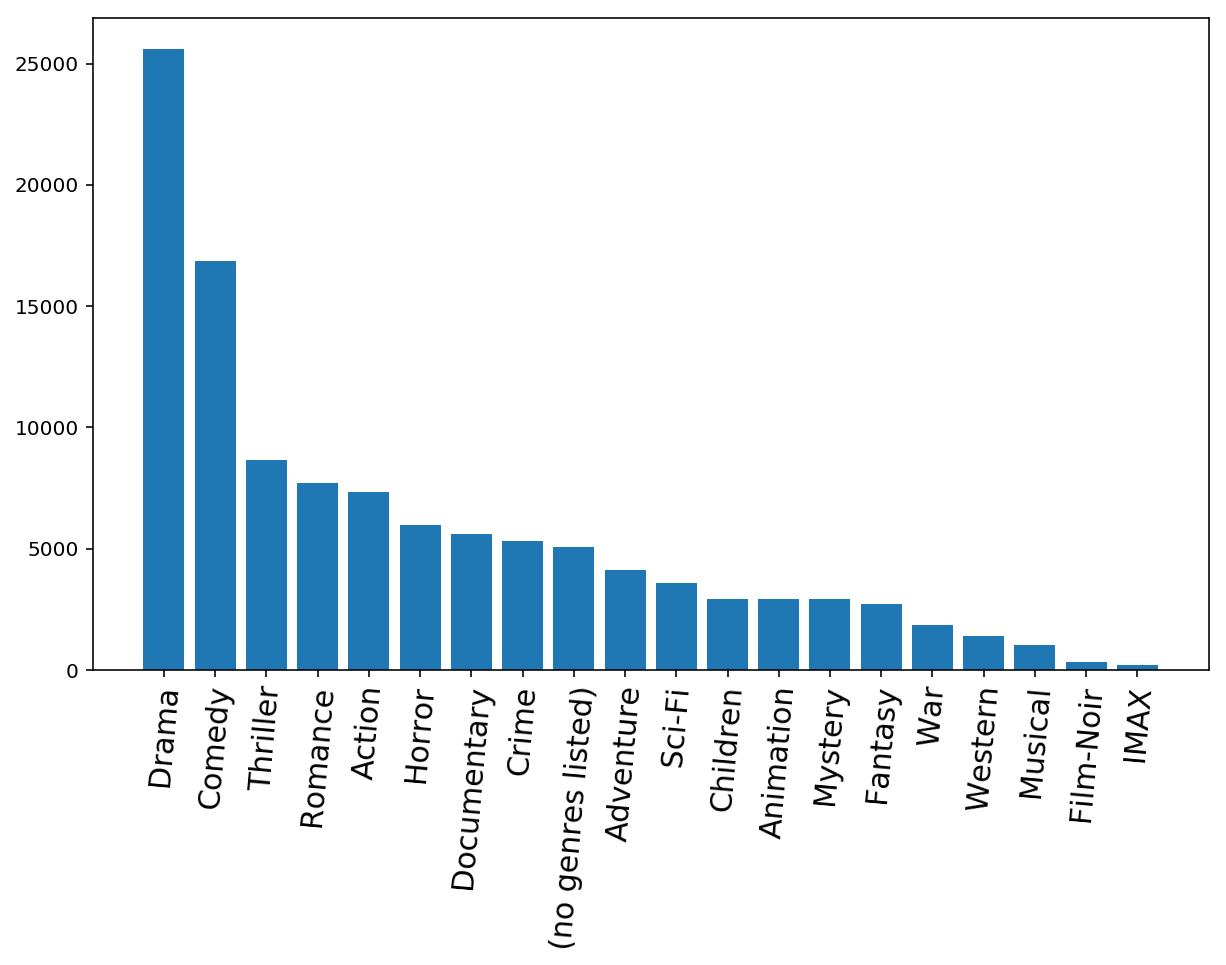

In [238]:
keys, values = zip(*genres_collected)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [11]:
######################################
######### YOUR CODE HERE #############
######################################
links = sc.textFile(LINKS_PATH)

In [12]:
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [13]:
links = links \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [14]:
links.take(5)

[(1, ['1', '0114709', '862']),
 (2, ['2', '0113497', '8844']),
 (3, ['3', '0113228', '15602']),
 (4, ['4', '0114885', '31357']),
 (5, ['5', '0113041', '11862'])]

In [15]:
tmdb = sc.textFile(TMDB_PATH)

In [16]:
tmdb_stats = tmdb \
    .map(lambda x: json.loads(x)) \
    .filter(lambda x: 'id' in x) \
    .keyBy(lambda x: x["id"])

In [481]:
movies.take(5)

['1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance',
 '5,Father of the Bride Part II (1995),Comedy']

In [304]:
movies_tmdb_id = movies \
    .join(links) \
    .keyBy(lambda x: x[1][1][2]) \
    .mapValues(lambda x: x[1][0][1])

In [306]:
movies_tmdb_id.take(5)[1]

('98536', 'So Big! (1932)')

#### 1: Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`


In [365]:
actors_films = tmdb_stats \
    .map(lambda f: (f[1]['title'], f[1]['casts']['cast'])) \
    .flatMapValues(lambda c: c) \
    .mapValues(lambda c: (c['id'], c['name']))

In [366]:
actors_films \
    .filter(lambda kv: kv[1][0] == 31) \
    .map(lambda x: x[0]) \
    .collect()

['Toy Story',
 'Apollo 13',
 'Forrest Gump',
 'Philadelphia',
 'Sleepless in Seattle',
 'The Celluloid Closet',
 'That Thing You Do!',
 'Saving Private Ryan',
 "The 'Burbs",
 'Splash',
 'The Money Pit',
 'Nothing in Common',
 "You've Got Mail",
 'Big',
 'Return with Honor',
 'Toy Story 2',
 'The Bonfire of the Vanities',
 'The Green Mile',
 'A League of Their Own',
 'Volunteers',
 'Bachelor Party',
 'Punchline',
 'Cast Away',
 'Turner & Hooch',
 "He Knows You're Alone",
 'Joe Versus the Volcano',
 'Road to Perdition',
 'Catch Me If You Can',
 'Radio Flyer',
 'Dragnet',
 'The Ladykillers',
 'The Terminal',
 'The Man with One Red Shoe',
 'The Polar Express',
 'The Da Vinci Code',
 'Cars',
 'The Simpsons Movie',
 "Charlie Wilson's War",
 'The Great Buck Howard',
 'Angels & Demons',
 'Shooting War',
 'Toy Story 3',
 'The Pixar Story',
 'Larry Crowne',
 'Extremely Loud & Incredibly Close',
 'Beyond All Boundaries',
 'Cloud Atlas',
 'Captain Phillips',
 'Toy Story of Terror!',
 'Saving Mr. B

#### 2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [377]:
actors_films.take(3)

[('Toy Story', (31, 'Tom Hanks')),
 ('Toy Story', (12898, 'Tim Allen')),
 ('Toy Story', (7167, 'Don Rickles'))]

In [383]:
actors_films \
    .map(lambda x: (x[1][0], (x[1][1], x[0], 1))) \
    .reduceByKey(lambda cum, x: (x[0], x[1], cum[2] + x[2])) \
    .sortBy(lambda key_value: key_value[1][2], ascending=False)\
    .map(lambda kv: (kv[1][0], kv[1][2])) \
    .take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 130)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [153]:
movies = sc.textFile(MOVIES_PATH)

movies = movies \
    .map(lambda s: comma_matcher.split(s)) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [154]:
movies.take(5)

[(1, ['1', 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy']),
 (2, ['2', 'Jumanji (1995)', 'Adventure|Children|Fantasy']),
 (3, ['3', 'Grumpier Old Men (1995)', 'Comedy|Romance']),
 (4, ['4', 'Waiting to Exhale (1995)', 'Comedy|Drama|Romance']),
 (5, ['5', 'Father of the Bride Part II (1995)', 'Comedy'])]

In [155]:
movies_with_year = movies \
    .join(links) \
    .keyBy(lambda x: x[1][1][2]) \
    .filter(lambda x: x[0].isnumeric()) \
    .map(lambda kv: (int(kv[0]), (kv[1][1][0][1], kv[1][1][0][2]))) \
    .join(tmdb_stats) \
    .map(lambda kv: (kv[0], (kv[1][0][0], kv[1][0][1], kv[1][1]['release_date'][:4]))) \
    .filter(lambda x: x[1][2].isnumeric())

In [156]:
movies_with_year.take(5)

[(16387,
  ("Daleks' Invasion Earth: 2150 A.D. (1966)", 'Adventure|Sci-Fi', '1966')),
 (98308, ('Teen Vamp (1988)', 'Comedy|Horror', '1988')),
 (458759, ('Interlude In Prague (2017)', '(no genres listed)', '2017')),
 (52920,
  ('What Will You Do When You Catch Me? (Co mi zrobisz jak mnie zlapiesz?) (1978)',
   'Comedy|Crime',
   '1978')),
 (14, ('American Beauty (1999)', 'Drama|Romance', '1999'))]

In [158]:
year_genre_sum = movies_with_year \
    .map(lambda f: (f[1][2], f[1][1].split('|'))) \
    .flatMapValues(lambda g: g) \
    .filter(lambda x: x[1] != '(no genres listed)') \
    .map(lambda kv: ((kv[0], kv[1]), 1)) \
    .reduceByKey(add) \

In [159]:
year_genre_sum.take(5)

[(('1981', 'Romance'), 45),
 (('1987', 'Comedy'), 181),
 (('2005', 'Thriller'), 202),
 (('1969', 'Children'), 14),
 (('1931', 'Documentary'), 4)]

In [160]:
years = movies_with_year.map(lambda x: x[1][2]).distinct()

In [161]:
genres = year_genre_sum.map(lambda x: x[0][1]).distinct().collect()

In [162]:
genres

['Action',
 'Horror',
 'Western',
 'IMAX',
 'Mystery',
 'Musical',
 'Fantasy',
 'Thriller',
 'Children',
 'Romance',
 'Documentary',
 'Sci-Fi',
 'War',
 'Animation',
 'Comedy',
 'Film-Noir',
 'Drama',
 'Adventure',
 'Crime']

In [163]:
all_genres_by_year = years \
    .map(lambda x: (x, genres)) \
    .flatMapValues(lambda g: g) \
    .map(lambda x: ((x[0], x[1]), 0)) \

In [164]:
all_genres_by_year = all_genres_by_year \
    .leftOuterJoin(year_genre_sum) \
    .sortByKey() \
    .map(lambda x: (x[0], x[1][1] if x[1][1] is not None else x[1][0])) \


In [165]:
n_films_by_year = all_genres_by_year \
    .map(lambda kv: (kv[0][0], kv[1])) \
    .reduceByKey(add) \


In [166]:
eps = 0.0001

In [167]:
genre_perc = all_genres_by_year \
    .map(lambda x: (x[0][0], (x[0][1], x[1]))) \
    .join(n_films_by_year) \
    .map(lambda kv: ((kv[1][0][0], kv[0]), kv[1][0][1] / (kv[1][1]+eps))) \
    .sortByKey() \

In [168]:
genre_perc.take(5)

[(('Action', '1874'), 0.0),
 (('Action', '1878'), 0.0),
 (('Action', '1881'), 0.0),
 (('Action', '1883'), 0.0),
 (('Action', '1887'), 0.0)]

In [169]:
genre_names = genre_perc.map(lambda x: x[0][0]).distinct().sortBy(lambda x: x).collect()

In [170]:
years = genre_perc.map(lambda x: x[0][1]).distinct().sortBy(lambda x: x).collect()

In [171]:
years

['1874',
 '1878',
 '1881',
 '1883',
 '1887',
 '1888',
 '1890',
 '1891',
 '1892',
 '1894',
 '1895',
 '1896',
 '1897',
 '1898',
 '1899',
 '1900',
 '1901',
 '1902',
 '1903',
 '1904',
 '1905',
 '1906',
 '1907',
 '1908',
 '1909',
 '1910',
 '1911',
 '1912',
 '1913',
 '1914',
 '1915',
 '1916',
 '1917',
 '1918',
 '1919',
 '1920',
 '1921',
 '1922',
 '1923',
 '1924',
 '1925',
 '1926',
 '1927',
 '1928',
 '1929',
 '1930',
 '1931',
 '1932',
 '1933',
 '1934',
 '1935',
 '1936',
 '1937',
 '1938',
 '1939',
 '1940',
 '1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 

In [172]:
genre_percs = genre_perc.map(lambda x: (x[0][0], x[1])).groupByKey().map(lambda x : list(x[1])).collect()

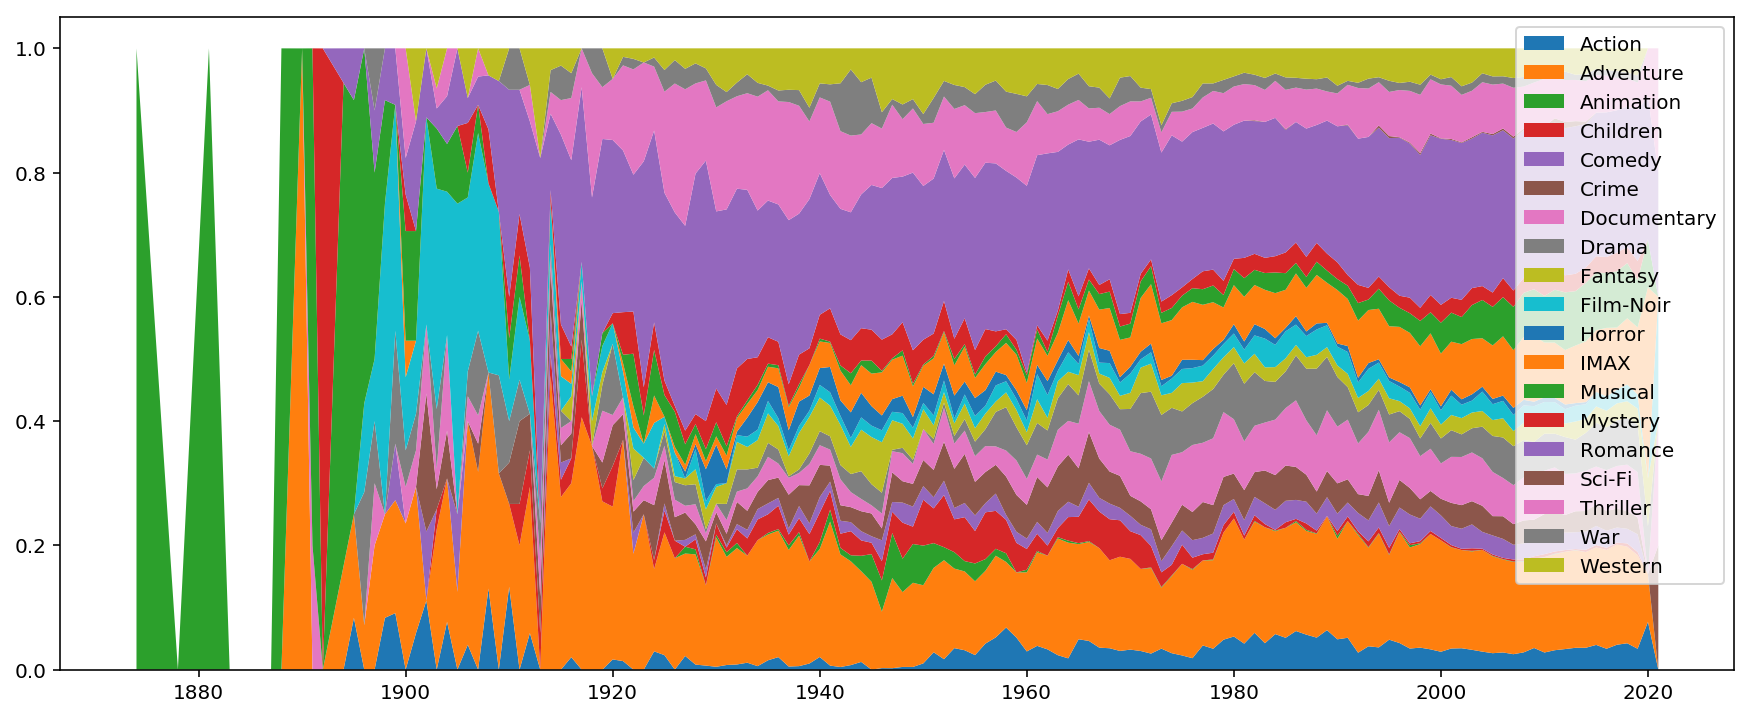

In [174]:
f, ax = plt.subplots(figsize=(15, 6))


plt.stackplot(list(map(int, years)), genre_percs, labels=genre_names)
plt.legend()
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [186]:
######################################
######### YOUR CODE HERE #############
######################################

movies_with_revenue = movies \
    .join(links) \
    .keyBy(lambda x: x[1][1][2]) \
    .filter(lambda x: x[0].isnumeric()) \
    .map(lambda kv: (int(kv[0]), (kv[1][1][0][1], kv[1][1][0][2]))) \
    .join(tmdb_stats) \
    .map(lambda kv: (kv[0], (kv[1][0][0], kv[1][0][1], kv[1][1]['revenue'], kv[1][1]['budget']))) \

In [187]:
movies_with_revenue.take(5)

[(16387,
  ("Daleks' Invasion Earth: 2150 A.D. (1966)", 'Adventure|Sci-Fi', 0, 797681)),
 (98308, ('Teen Vamp (1988)', 'Comedy|Horror', 0, 0)),
 (458759, ('Interlude In Prague (2017)', '(no genres listed)', 0, 0)),
 (52920,
  ('What Will You Do When You Catch Me? (Co mi zrobisz jak mnie zlapiesz?) (1978)',
   'Comedy|Crime',
   0,
   0)),
 (14, ('American Beauty (1999)', 'Drama|Romance', 356296601, 15000000))]

In [188]:
roi = movies_with_revenue \
    .map(lambda f: ((f[1][2], f[1][3]), f[1][1].split('|'))) \
    .flatMapValues(lambda g: g) \
    .filter(lambda x: x[1] != '(no genres listed)') \
    .map(lambda kv: (kv[1], ((kv[0][0], 1), ((kv[0][1], 1))))) \
    .reduceByKey(lambda cum, x: ((cum[0][0] + x[0][0], cum[0][1] + x[0][1]), (cum[1][0] + x[1][0], cum[1][1] + x[1][1]))) \
    .mapValues(lambda x: (x[0][0]/x[0][1]) / (x[1][0]/x[1][1])) \
    .collect()

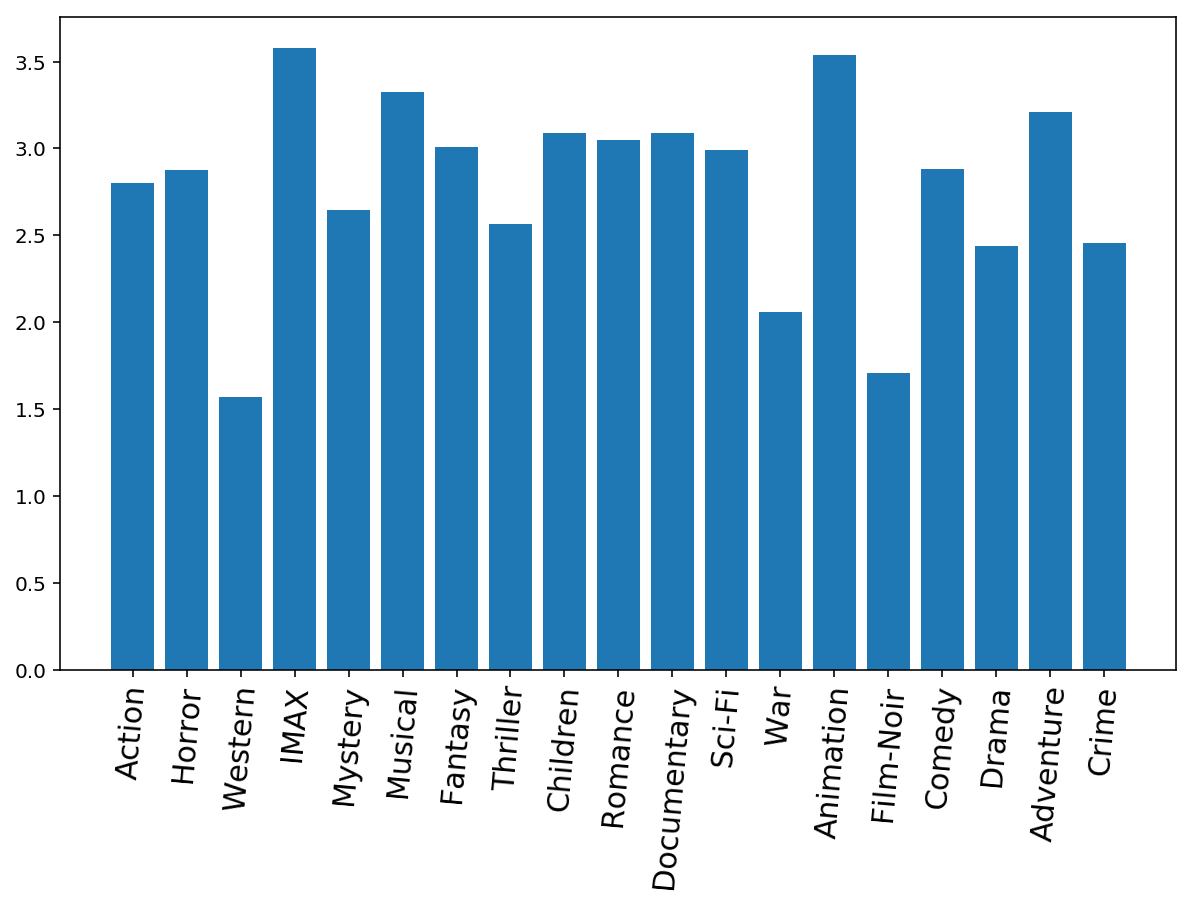

In [189]:
keys, values = zip(*roi)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()